In [2]:
import numpy as np
import json
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
import seaborn as sns


In [4]:
import pandas as pd

## Data Analysis


In [5]:
with open('train_annotations.json', 'r') as f:
    train_data = json.load(f)
    
# Load evaluation data
with open('sample_answer.json', 'r') as f:
    eval_data = json.load(f)

print(f"Number of images in training data: {len(train_data['images'])}")
print(f"Number of images in evaluation data: {len(eval_data['images'])}")

# Analyze image properties
def analyze_image_properties(data, dataset_name=""):
    # Extract image properties
    properties = pd.DataFrame([{
        'file_name': img['file_name'],
        'width': img['width'],
        'height': img['height'],
        'cm_resolution': img['cm_resolution'],
        'scene_type': img['scene_type'],
        'num_annotations': len(img['annotations']),
        'dataset': dataset_name
    } for img in data['images']])
    print(f"\n=== {dataset_name} Dataset Analysis ===")
    print(f"Total Images: {len(properties)}")
    print("Image Dimensions:", properties[['width', 'height']].drop_duplicates().values)
    
    print("\nResolution Distribution:")
    res_dist = properties['cm_resolution'].value_counts().sort_index()
    print(res_dist)
    print("\nScene Types:", properties['scene_type'].unique())
    
    print("\nAnnotations per Image:\n", properties['num_annotations'].describe())
    
    return properties

# Analyze both datasets
train_properties = analyze_image_properties(train_data, "Training")
eval_properties = analyze_image_properties(eval_data, "Evaluation")

# Combine properties for easier comparison
all_properties = pd.concat([train_properties, eval_properties])

Number of images in training data: 150
Number of images in evaluation data: 150

=== Training Dataset Analysis ===
Total Images: 150
Image Dimensions: [[1024 1024]]

Resolution Distribution:
cm_resolution
10    37
20    38
40    25
60    25
80    25
Name: count, dtype: int64

Scene Types: ['agriculture_plantation' 'rural_area' 'urban_area' 'open_field'
 'industrial_area']

Annotations per Image:
 count     150.000000
mean      259.413333
std       242.163187
min        16.000000
25%        78.000000
50%       150.500000
75%       403.250000
max      1030.000000
Name: num_annotations, dtype: float64

=== Evaluation Dataset Analysis ===
Total Images: 150
Image Dimensions: [[1024 1024]]

Resolution Distribution:
cm_resolution
10    38
20    37
40    25
60    25
80    25
Name: count, dtype: int64

Scene Types: ['industrial_area' 'urban_area' 'agriculture_plantation' 'open_field'
 'rural_area']

Annotations per Image:
 count    150.000000
mean      27.560000
std       12.057736
min       10

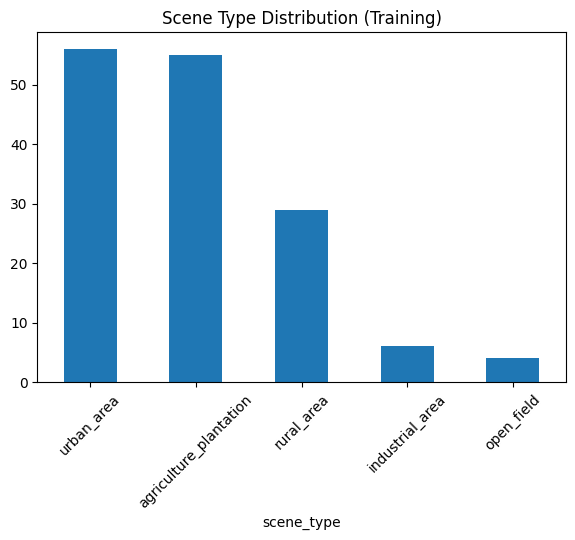

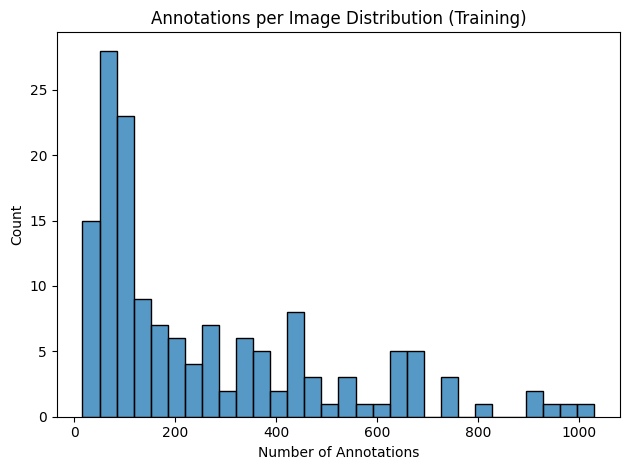

In [6]:
# Create visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Scene Type Distribution
plt.subplot(2, 2, 1)
train_properties['scene_type'].value_counts().plot(kind='bar')
plt.title('Scene Type Distribution (Training)')
plt.xticks(rotation=45)
plt.show()

sns.histplot(data=train_properties, x='num_annotations', bins=30)
plt.title('Annotations per Image Distribution (Training)')
plt.xlabel('Number of Annotations')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [7]:
from pathlib import Path
import re

def analyze_image_files(directory):
    # Get all .tif files
    image_files = list(Path(directory).glob('*.tif'))
    
    # Extract resolutions and counts
    resolution_pattern = re.compile(r'(\d+)cm')
    resolutions = {}
    
    for file in image_files:
        match = resolution_pattern.search(file.name)
        if match:
            res = int(match.group(1))
            resolutions[res] = resolutions.get(res, 0) + 1
    
    return {
        'total_images': len(image_files),
        'resolution_counts': resolutions,
        'total_size_mb': sum(file.stat().st_size / (1024 * 1024) for file in image_files)
    }

# Analyze both directories
train_stats = analyze_image_files('train_images')
eval_stats = analyze_image_files('evaluation_images')

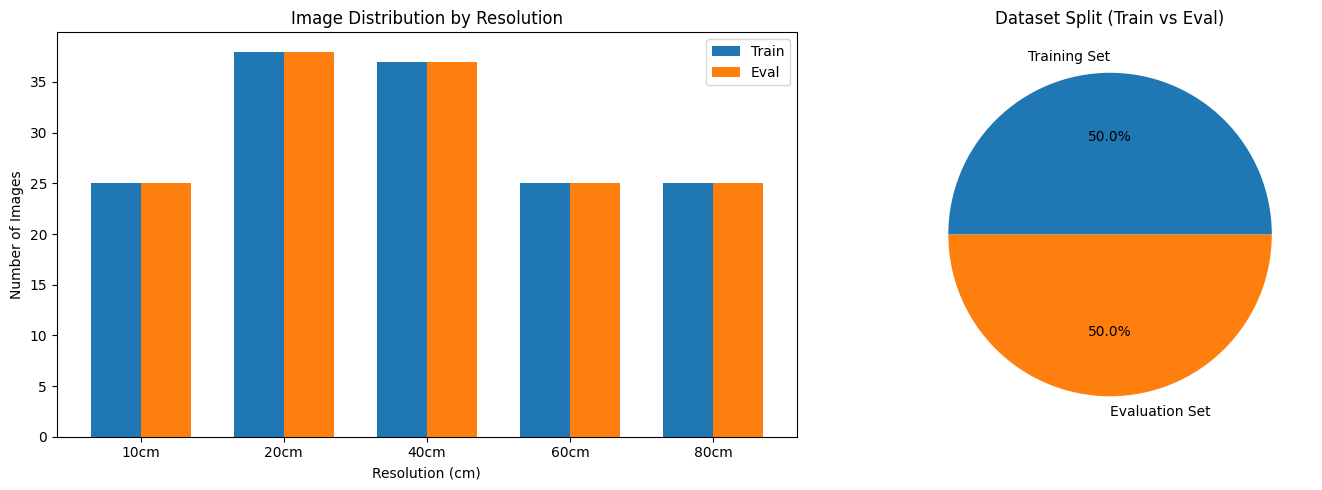

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x = np.arange(len(train_stats['resolution_counts']))
width = 0.35

plt.bar(x - width/2, train_stats['resolution_counts'].values(), width, label='Train')
plt.bar(x + width/2, eval_stats['resolution_counts'].values(), width, label='Eval')
plt.xlabel('Resolution (cm)')
plt.ylabel('Number of Images')
plt.title('Image Distribution by Resolution')
plt.xticks(x, [f"{res}cm" for res in sorted(train_stats['resolution_counts'].keys())])
plt.legend()

# Plot 2: Dataset Size Comparison
plt.subplot(1, 2, 2)
plt.pie([train_stats['total_images'], eval_stats['total_images']], 
        labels=['Training Set', 'Evaluation Set'],
        autopct='%1.1f%%')
plt.title('Dataset Split (Train vs Eval)')

plt.tight_layout()
plt.show()

In [9]:
# Print comparison statistics
print("\nDataset Comparison:")
print(f"Training set: {train_stats['total_images']} images ({train_stats['total_size_mb']:.2f} MB)")
print(f"Evaluation set: {eval_stats['total_images']} images ({eval_stats['total_size_mb']:.2f} MB)")
print(f"Total dataset: {train_stats['total_images'] + eval_stats['total_images']} images "
      f"({train_stats['total_size_mb'] + eval_stats['total_size_mb']:.2f} MB)")

# Calculate and print resolution-wise split
print("\nResolution-wise Split:")
print(f"{'Resolution':<10} {'Train':<8} {'Eval':<8} {'Ratio':<8}")
print("-" * 35)
for res in sorted(train_stats['resolution_counts'].keys()):
    train_count = train_stats['resolution_counts'].get(res, 0)
    eval_count = eval_stats['resolution_counts'].get(res, 0)
    ratio = train_count / eval_count if eval_count > 0 else float('inf')
    print(f"{res:3d}cm      {train_count:<8d} {eval_count:<8d} {ratio:.2f}")



Dataset Comparison:
Training set: 150 images (450.04 MB)
Evaluation set: 150 images (450.04 MB)
Total dataset: 300 images (900.08 MB)

Resolution-wise Split:
Resolution Train    Eval     Ratio   
-----------------------------------
 10cm      37       38       0.97
 20cm      38       37       1.03
 40cm      25       25       1.00
 60cm      25       25       1.00
 80cm      25       25       1.00


## Converting To Dataset

In [26]:
import os
import json
import numpy as np
import pandas as pd
import cv2
# import rasterio
from tqdm.notebook import tqdm
import glob
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


class CFG:
    # --- Data paths
    BASE_PATH = "./"
    TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train_images")
    EVAL_IMG_PATH = os.path.join(BASE_PATH, "evaluation_images")
    TRAIN_ANNOT_PATH = os.path.join(BASE_PATH, "train_annotations.json")
    SAMPLE_SUB_PATH = os.path.join(BASE_PATH, "sample_answer.json")
    
    # --- Model parameters
    MODEL_ARC = "Segformer"
    BACKBONE = "efficientnet-b3"
    ENCODER_WEIGHTS = "imagenet"
    
    # --- Training parameters
    IMG_SIZE = 1024
    BATCH_SIZE = 2
    EPOCHS = 1
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    
    # --- Classes (discovered from annotations)
    CLASSES = ["individual_tree", "group_of_trees"]
    
    # --- Post-processing thresholds
    CONF_THRESHOLD = 0.5
    MIN_CONTOUR_AREA = 25
    
    # --- Visualization parameters
    NUM_SAMPLES_TO_VISUALIZE = 3


# --- Create class mappings
class_to_id = {name: i + 1 for i, name in enumerate(CFG.CLASSES)}
id_to_class = {i + 1: name for i, name in enumerate(CFG.CLASSES)}
NUM_CLASSES = len(CFG.CLASSES) + 1  # Add 1 for the background class

class CanopyDataset(Dataset):
    """Custom PyTorch Dataset for loading images and masks."""
    def __init__(self, image_dir, df, class_to_id, transforms=None, is_test=False):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
        self.df = df
        self.class_to_id = class_to_id
        self.transforms = transforms
        self.is_test = is_test

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        file_name = os.path.basename(image_path)
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.is_test:
            original_size = image.shape[:2]
            if self.transforms:
                transformed = self.transforms(image=image)
                image = transformed['image']
            return image, file_name, original_size

        height, width = image.shape[:2]
        
        # CORRECTED: Changed dtype to np.int32 for OpenCV compatibility
        mask = np.zeros((height, width), dtype=np.int32)
        
        annots = self.df[self.df['file_name'] == file_name]
        if not annots.empty:
            for _, row in annots.iterrows():
                class_id = self.class_to_id.get(row['class'])
                if class_id:
                    # CORRECTED: Ensured segmentation points are also np.int32
                    segmentation = np.array(row['segmentation'], dtype=np.int32).reshape(-1, 2)
                    cv2.fillPoly(mask, [segmentation], color=class_id)
        
        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # The mask needs to be converted back to long for PyTorch's CrossEntropyLoss
        return image, mask.long()

def get_transforms(img_size):
    """Define data augmentations for training and validation."""
    train_transforms = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    val_transforms = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
    
    return train_transforms, val_transforms

In [27]:
def denormalize(tensor):
    """Denormalize a tensor image with mean and standard deviation."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    tensor = tensor.clone().permute(1, 2, 0).cpu().numpy() # C, H, W -> H, W, C
    tensor = tensor * std + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def visualize(image, mask, title="Sample"):
    """Plot image, mask, and overlay."""
    # Create a color map for the mask
    # Class 0 (background): black, Class 1: blue, Class 2: yellow
    color_map = np.array([[0, 0, 0], [0, 0, 255], [255, 255, 0]], dtype=np.uint8)
    
    # Convert mask indices to a color image
    color_mask = color_map[mask]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
    
    ax1.imshow(image)
    ax1.set_title("Original Image")
    ax1.axis('off')
    
    ax2.imshow(color_mask)
    ax2.set_title("Mask")
    ax2.axis('off')
    
    # Overlay mask on the image
    overlay = cv2.addWeighted((image * 255).astype(np.uint8), 0.6, color_mask, 0.4, 0)
    ax3.imshow(overlay)
    ax3.set_title("Image with Overlay")
    ax3.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.show()

def parse_annotations(annot_path):
    """Parses the complex JSON into a flat pandas DataFrame."""
    with open(annot_path, 'r') as f:
        data = json.load(f)
    
    images_data = data['images']
    annotations_list = []
    
    for img_info in images_data:
        for annot in img_info['annotations']:
            annotations_list.append({
                'file_name': img_info['file_name'],
                'height': img_info['height'],
                'width': img_info['width'],
                'class': annot['class'],
                'segmentation': annot['segmentation']
            })
            
    return pd.DataFrame(annotations_list)


# Load and prepare annotations
def prepare_annotations_df():
    with open(CFG.TRAIN_ANNOT_PATH, 'r') as f:
        train_data = json.load(f)
    
    # Flatten the annotations
    annotations = []
    for img in train_data['images']:
        for ann in img['annotations']:
            annotations.append({
                'file_name': img['file_name'],
                'class': ann['class'],
                'segmentation': ann['segmentation']
            })
    
    return pd.DataFrame(annotations)

# Create visualization function
def visualize_image_with_mask(dataset, idx, title=None):
    """
    Visualize an image and its corresponding mask from the dataset
    """
    image, mask = dataset[idx]
    
    # Convert tensor to numpy and denormalize
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    
    # Create a color mask
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
    for class_idx in range(1, NUM_CLASSES):  # Skip background (0)
        colored_mask[mask == class_idx] = plt.cm.Set3(class_idx / NUM_CLASSES)[:3]
    
    plt.figure(figsize=(15, 5))
    
    # Plot original image
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot mask
    plt.subplot(132)
    plt.imshow(mask, cmap='tab20')
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    # Plot overlay
    plt.subplot(133)
    plt.imshow(image)
    plt.imshow(colored_mask, alpha=0.4)
    plt.title('Overlay')
    plt.axis('off')
    
    if title:
        plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()


Preparing annotations...
Creating dataset...

Visualizing examples...


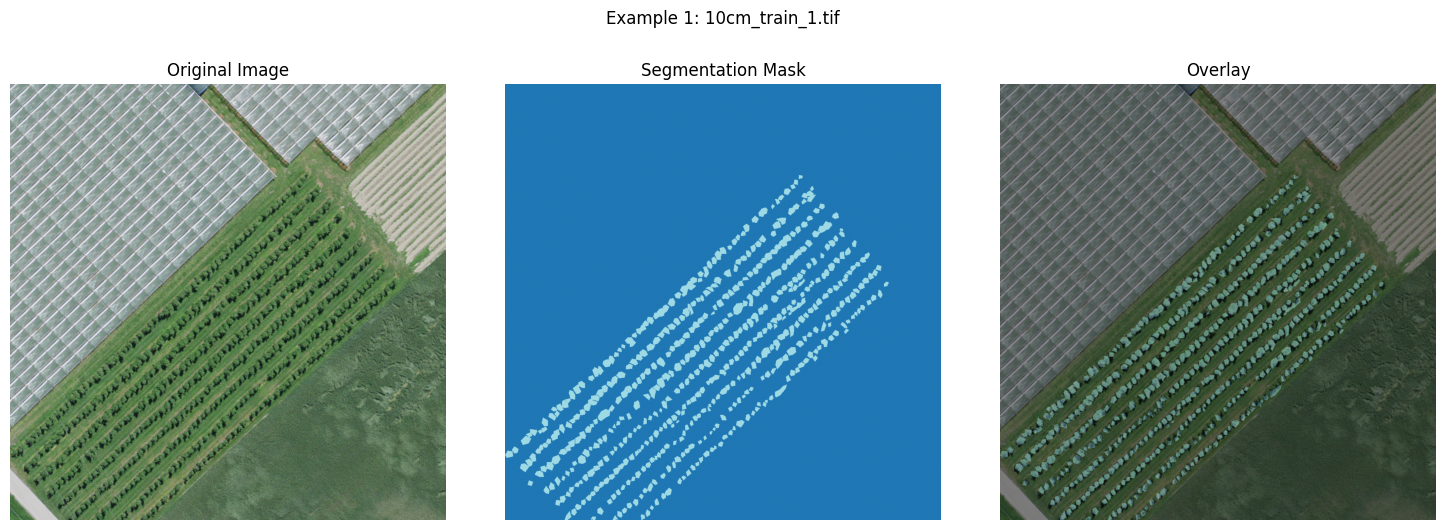

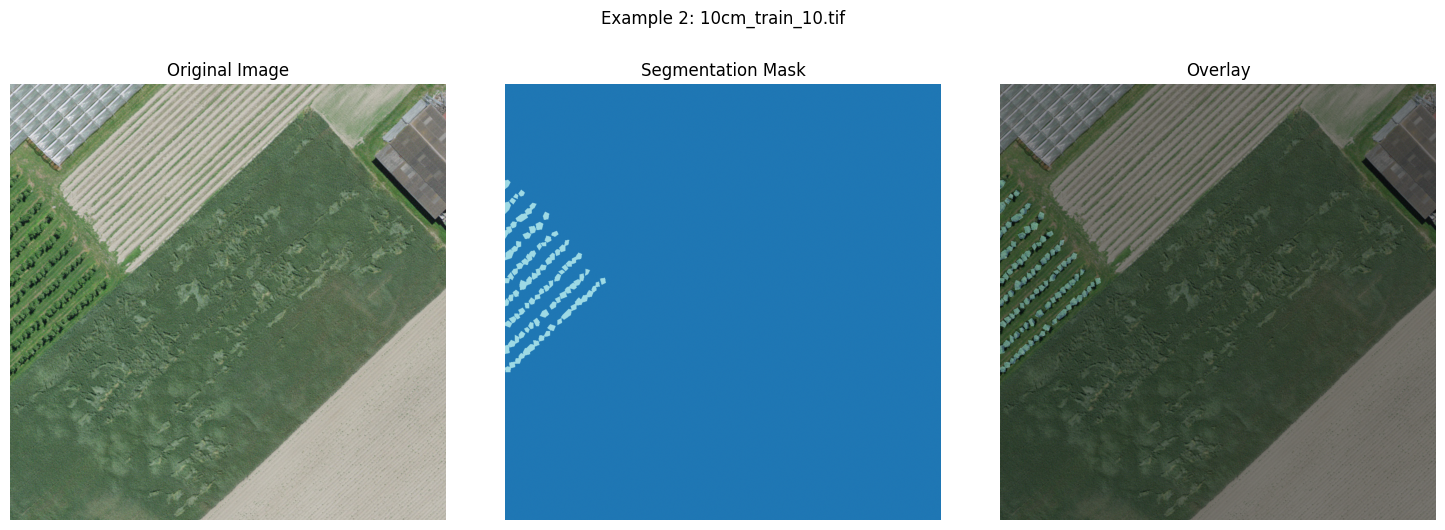

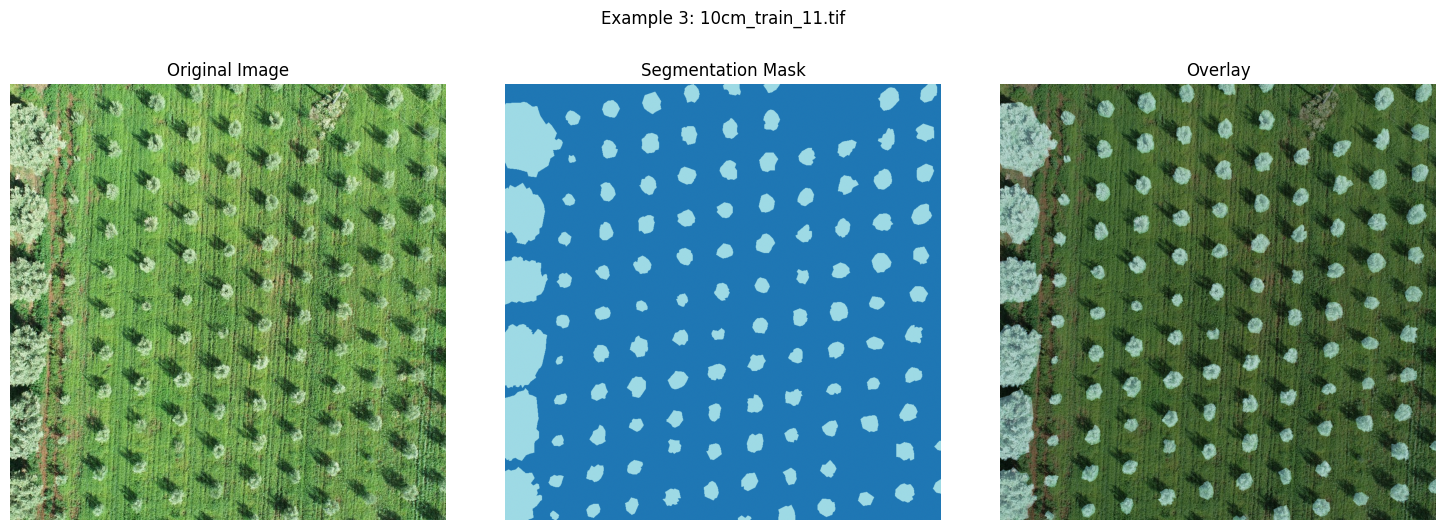

In [28]:
print("Preparing annotations...")
train_df = prepare_annotations_df()
train_transforms, _ = get_transforms(CFG.IMG_SIZE)

print("Creating dataset...")
train_dataset = CanopyDataset(
    image_dir=CFG.TRAIN_IMG_PATH,
    df=train_df,
    class_to_id=class_to_id,
    transforms=train_transforms
)

print("\nVisualizing examples...")
for i in range(3):  # Show 3 examples
    try:
        image_path = train_dataset.image_paths[i]
        file_name = os.path.basename(image_path)
        visualize_image_with_mask(train_dataset, i, 
                                f"Example {i+1}: {file_name}")
    except Exception as e:
        print(f"Error visualizing example {i}: {str(e)}")

## Running UNet

In [32]:

def build_model():
    """Builds the Segmentation Model."""
    model = smp.Unet(
        encoder_name=CFG.BACKBONE,
        encoder_weights=CFG.ENCODER_WEIGHTS,
        in_channels=3,
        classes=NUM_CLASSES 
    )
    return model.to(CFG.DEVICE)

class CombinedLoss(torch.nn.Module):
    """Wrapper class to combine Dice Loss and Cross-Entropy Loss."""
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass')
        self.ce_loss = torch.nn.CrossEntropyLoss()

    def forward(self, outputs, masks):
        return self.dice_loss(outputs, masks) + self.ce_loss(outputs, masks)

def train_one_epoch(model, dataloader, optimizer, criterion):
    """Runs a single training epoch."""
    model.train()
    epoch_loss = 0.0
    
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(CFG.DEVICE)
        masks = masks.to(CFG.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

In [39]:

def run_training():
    """Main function to orchestrate the training process."""
    print(f"Using device: {CFG.DEVICE}")
    
    df_annots = parse_annotations(CFG.TRAIN_ANNOT_PATH)
    train_transforms, _ = get_transforms(CFG.IMG_SIZE)
    
    train_dataset = CanopyDataset(
        image_dir=CFG.TRAIN_IMG_PATH, df=df_annots,
        class_to_id=class_to_id, transforms=train_transforms,
    )
    train_loader = DataLoader(
        train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=0
    )
    
    model = build_model()
    # compile the model
    # model = torch.compile(model)
    criterion = CombinedLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR)
    
    best_loss = float('inf')
    for epoch in range(CFG.EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        print(f"Epoch {epoch+1}/{CFG.EPOCHS}, Train Loss: {train_loss:.4f}")
        
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Model saved with loss: {best_loss:.4f}")
            
    print("Training finished.")
    return model

In [40]:
CFG.EPOCHS = 10

CFG.EPOCHS

10

In [41]:
print("Visualizing some training samples...")
df_annots_vis = parse_annotations(CFG.TRAIN_ANNOT_PATH)
train_transforms_vis, _ = get_transforms(CFG.IMG_SIZE)
vis_dataset = CanopyDataset(
    image_dir=CFG.TRAIN_IMG_PATH, df=df_annots_vis,
    class_to_id=class_to_id, transforms=train_transforms_vis,
)

# Step 1: Train the model
run_training()


Visualizing some training samples...
Using device: mps


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 1.4929
Model saved with loss: 1.4929


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 1.1916
Model saved with loss: 1.1916


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 1.0565
Model saved with loss: 1.0565


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 0.9627
Model saved with loss: 0.9627


Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 0.9166
Model saved with loss: 0.9166


Training:   0%|          | 0/75 [00:00<?, ?it/s]

KeyboardInterrupt: 


Loading best model for inference and visualization...
Visualizing some evaluation predictions...
>> epochs: 10


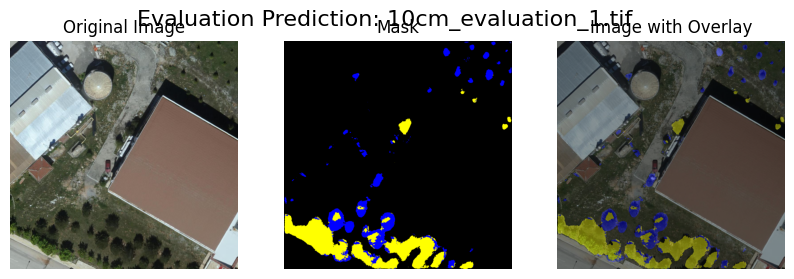

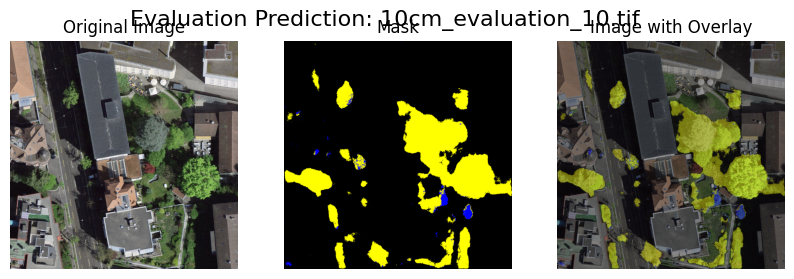

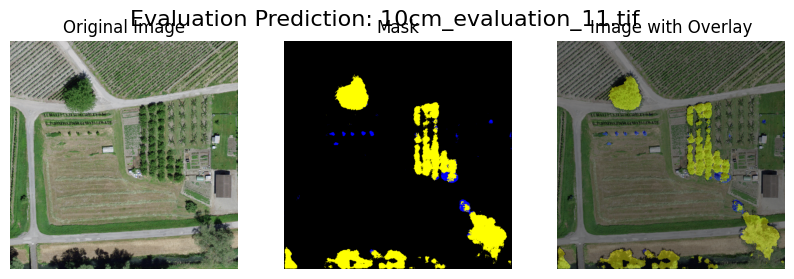

In [42]:

print("\nLoading best model for inference and visualization...")
best_model = build_model()
best_model.load_state_dict(torch.load("best_model.pth", map_location=CFG.DEVICE))
best_model.eval()

# --- Visualize some evaluation predictions
print("Visualizing some evaluation predictions...")
_, test_transforms_vis = get_transforms(CFG.IMG_SIZE)
eval_vis_dataset = CanopyDataset(
    image_dir=CFG.EVAL_IMG_PATH, df=None, class_to_id=None,
    transforms=test_transforms_vis, is_test=True
)

print(f">> epochs: {CFG.EPOCHS}")
with torch.no_grad():
    for i in range(CFG.NUM_SAMPLES_TO_VISUALIZE):
        img_tensor, file_name, _ = eval_vis_dataset[i]
        
        # Predict
        logits = best_model(img_tensor.unsqueeze(0).to(CFG.DEVICE))
        pred_mask = torch.argmax(logits, dim=1).squeeze().cpu().numpy()
        
        # Visualize
        img_np = denormalize(img_tensor)
        visualize(img_np, pred_mask, title=f"Evaluation Prediction: {file_name}")


## Setting Up DINOV3/SAM2/detectron